In [66]:
import numpy as np 
from scipy.linalg import cholesky, qr, norm
import matplotlib.pyplot as plt
dim = 100 # size of the matrices used in this lab

# SPD Matrices and Cholesky 

A symmetric matrix $\mathbf{A} \in \mathbb{R}^{n \times n}$ is positive definite (PD) if
$$
\boldsymbol{x}^T\mathbf{A}\boldsymbol{x} > 0 \quad \text{for every nonzero } \boldsymbol{x} \in \mathbb{R}^n.
$$


In [67]:
# Lets start by creating a random SPD matrix
A = np.random.rand(dim, dim)
A = A @ A.T # you can theoretically check this at your own lesiure ( if A is full rank, A * A^t is SPD)

# check SPD properties
def is_spd(A):
    symmetric = np.all(A == A.T)
    positive_definite = np.all(np.linalg.eigvals(A) > 0) # all eigvals positive
    return symmetric & positive_definite

# check ig matrix satisfies both properties
assert is_spd(A)

### Cholesky Decomposition

**Definition.** Let $A \in \mathbb{R}^{n \times n}$ be symmetric positive definite. The **Cholesky decomposition** of $A$ is the unique factorization

$$
A = L\,L^T,
$$

where $L$ is a lower‐triangular matrix with strictly positive diagonal entries.

#### Algorithm

For an SPD matrix $A \in \mathbb{R}^{n \times n}$, the factorization $A = L\,L^T$ can be computed entry‑wise as:

$$
l_{ij} =
\begin{cases}
0, & \text{if } i < j,\\[6pt]
\displaystyle \sqrt{\,a_{ii} - \sum_{k=1}^{i-1} l_{ik}^2\,}, & \text{if } i = j,\\[10pt]
\displaystyle \frac{1}{l_{jj}}\Bigl(a_{ij} - \sum_{k=1}^{j-1} l_{ik}\,l_{jk}\Bigr), & \text{if } i > j,
\end{cases}
$$

for $i,j = 1,\dots,n$. Please refer to this week's readings for the derivation.


In [68]:
def _cholesky(A):
    
    n = A.shape[0]
    L = np.zeros(shape = A.shape)
    
    # check spd
    if not is_spd(A):
        print("input not SPD")
        return L 
    
    # loop through each pivot
    for i in range(n):
        for j in range(i+1): # compute values below the pivot
            if i == j:
                L[i, i] = np.sqrt(A[i, i] - np.sum(L[i, :i]**2))
            else:
                L[i, j] = (A[i, j] - np.sum(L[i, :j] * L[j, :j])) / L[j, j]

    return L


In [69]:
# testing our cholesky function
L = _cholesky(A)
A_reconstructed = L @ L.T

# testing if factorization is accurate 
assert np.allclose(A_reconstructed, A), "Error in reconstructing A"
assert np.allclose(np.linalg.cholesky(A), L), "implemented function does not match numpy result!"

## Orthogonal Matrices
**Definition:** A square matrix $Q \in \mathbb{R}^{n \times n}$ is **orthogonal** if its columns (and rows) form an orthonormal set, i.e.

$$Q^T Q = Q Q^T = I_n.$$ 

Equivalently, $Q^{-1} = Q^T$. Orthogonal matrices preserve Euclidean norms and angles:

$$\|Qx\|_2 = \|x\|_2, \qquad (Qx)\cdot(Qy) = x\cdot y \quad \forall x,y\in\mathbb{R}^n.$$

### QR Decomposition
**Definition:** Let $A \in \mathbb{R}^{m \times n}$ with full column rank ($m \ge n$). A QR factorization of $A$ is the decomposition $A = QR$, where:
- $Q \in \mathbb{R}^{m \times n}$ has orthonormal columns ($Q^T Q = I_n$).
- $R \in \mathbb{R}^{n \times n}$ is upper‐triangular with positive diagonal entries.

In [93]:
A = np.random.rand(dim, dim)
Q, R = qr(A)

assert np.allclose(Q.T, np.linalg.inv(Q)) # inv(Q) = Q^t 
assert np.allclose(Q@Q.T, np.eye(dim)) # Q Q' = I 
assert np.allclose(R, np.triu(R)) # R should be upper triangular
assert np.allclose(Q@R, A) # Q R = A

### Condition number and Stability
The condition number $\kappa$ of a matrix $A$ measures how much the exact solution can change in response to small changes in the input:
$$
\kappa(A) = \|A\|\,\|A^{-1}\|.
$$

- **Conditioning** is a property of the *problem*—it tells you how sensitive the true solution $x$ is to perturbations in $A$ or $b$.  
- **Stability** is a property of the *algorithm*—it tells you how errors (round‑off, truncation, etc.) incurred during the computation propagate into the final result.

For an SPD matrix $A\in\mathbb{R}^{d\times d}$ with eigenvalues
$$
\lambda_1\ge \lambda_2 \ge \cdots \ge \lambda_d>0,
$$
its condition number is
$$
\kappa(A) \;=\;\frac{\lambda_1}{\lambda_d}.
$$
If we choose a diagonal matrix
$$
\Lambda = \mathrm{diag}(\lambda_1,\dots,\lambda_d)
$$
with $\lambda_1=\kappa$, $\lambda_d=1$, and intermediate $\lambda_i$ (e.g.\ linearly spaced), then for any orthonormal $Q$,
$$
A = Q\,\Lambda\,Q^T
$$
is SPD and satisfies $\kappa(A)=\kappa$.

We will use these properties to write a function to generate a random SPD matrix with a given condition number


In [76]:
def generate_spd_with_cond(d, kappa):
    """
    Build an SPD matrix of size d×d whose eigenvalues
    are linearly spaced from λ₁ = kappa down to λ_d = 1.
    Hence cond(A) = kappa.
    """
    Q, _ = np.linalg.qr(np.random.randn(d, d))
    eigs = np.linspace(kappa, 1.0, d)
    return Q @ np.diag(eigs) @ Q.T

Excercise: Using these methods  *construct* an SPD matrix whose condition number is exactly $\kappa$, and then compare the numerical stability of four factorizations:
1. Cholesky  
2. QR  
3. LU **without** pivoting  
4. LU **with** (partial) pivoting  

In [110]:
# parameters
k   = 10

# choose condition numbers linearly from 10¹ up to 10⁶
kappas = np.linspace(1e1, 1e15, k)          
chol_res = []
qr_res   = []

for kappa in kappas:
    A = generate_spd_with_cond(dim, kappa)

    # Cholesky residual
    R = cholesky(A, lower=False)
    chol_res.append(norm(A - R.T @ R, ord='fro'))

    # QR factorization residual
    Q, Rq = qr(A)
    qr_res.append(norm(A - Q @ Rq, ord='fro'))

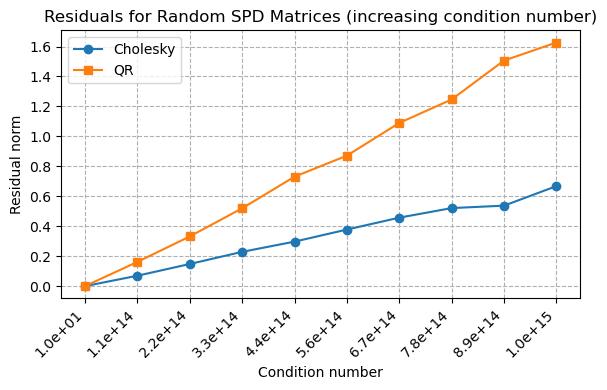

In [111]:
plt.figure(figsize=(6,4))
plt.plot(chol_res, 'o-', label='Cholesky')
plt.plot(qr_res, 's-', label='QR')

# label x axis with the corrosponding matrix's condition numbers
plt.xticks(
    ticks=range(len(kappas)),
    labels=[f"{κ:.1e}" for κ in kappas],
    rotation=45,
    ha='right'
)

plt.xlabel('Condition number')
#plt.yscale('log') # uncomment this for log scale
plt.ylabel('Residual norm')
plt.title('Residuals for Random SPD Matrices (increasing condition number)')
plt.legend()
plt.grid(which='both', ls='--')
plt.tight_layout()
plt.show()